# Import

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
import openai

#sys.path.append('../..')

env_path = find_dotenv()

_ = load_dotenv(find_dotenv()) # read local .env file

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY', 'Default_API_Key')

print("LANGCHAIN_TRACING_V2:", os.getenv('LANGCHAIN_TRACING_V2'))
print("LANGCHAIN_ENDPOINT:", os.getenv('LANGCHAIN_ENDPOINT'))
print("LANGCHAIN_API_KEY:", os.getenv('LANGCHAIN_API_KEY'))

openai.api_key  = os.environ['OPENAI_API_KEY']


LANGCHAIN_TRACING_V2: true
LANGCHAIN_ENDPOINT: https://api.smith.langchain.com
LANGCHAIN_API_KEY: ls__635becc6fd374541b76e9bcb82942732


# Index

In [5]:
from langchain_openai import OpenAIEmbeddings
persist_directory="../../vectorstore/chroma"

from langchain_community.vectorstores import Chroma

if os.path.exists(persist_directory):
    # If the vector store exists, load it
    vectorstore = Chroma(persist_directory=persist_directory, embedding_function=OpenAIEmbeddings())
else:
    print('Vectorestore directory not Found')
retriever = vectorstore.as_retriever()


# Generate multi query
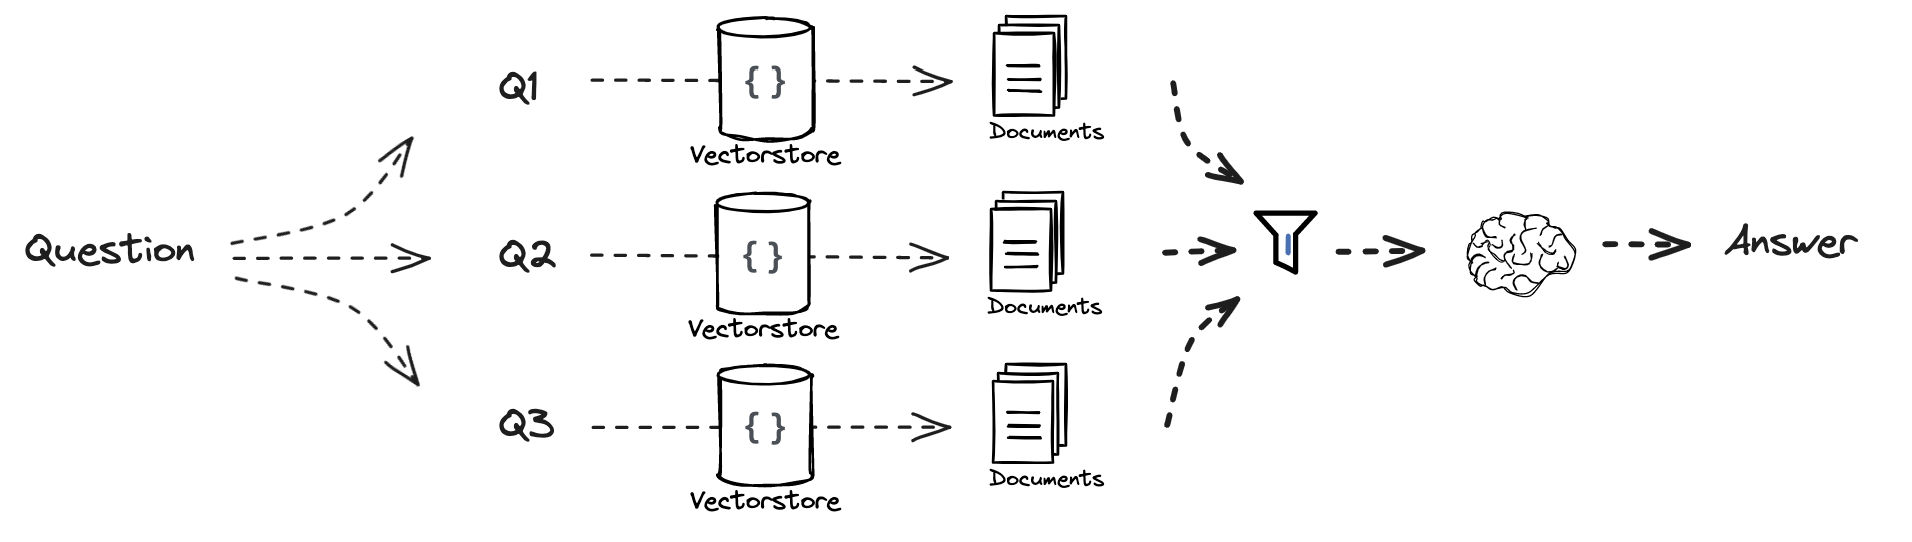

In [6]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [7]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)
retrieval_chain_rag_fusion = generate_queries | retriever.map()

In [8]:
question = "OFAC ?"
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

4

In [9]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# RAG
template = """Answer the following question based on this context:
If you don't know this asnwer, say it.

Context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)
print(f"Question : {question}")
final_rag_chain.invoke({"question":question})

Question : OFAC ?


'OFAC stands for Central Africa Forest Observatory.'